In [839]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

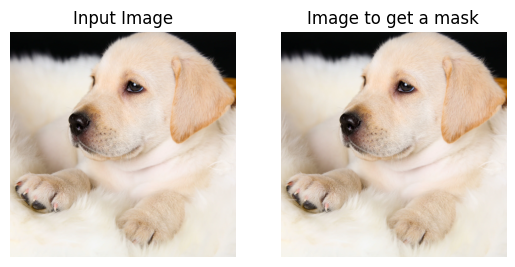

In [840]:
input_image_path = "dog.jpg" 
mask_image_path = "dog.jpg" 

input_image = cv2.imread(input_image_path)
input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)
mask_image = cv2.imread(mask_image_path)
mask_image = cv2.cvtColor(mask_image, cv2.COLOR_BGR2RGB)

plt.subplot(1, 2, 1)
plt.imshow(input_image)
plt.title('Input Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(mask_image)
plt.title('Image to get a mask')
plt.axis('off')
plt.show()


In [841]:
def getMask(mask_image):
    rect_roi = cv2.selectROI(mask_image)
    cv2.destroyAllWindows()

    return input_image[int(rect_roi[1]):int(rect_roi[1]+rect_roi[3]),
                int(rect_roi[0]):int(rect_roi[0]+rect_roi[2])] 

def getRegionToMask(input_image):
    rect_roi = cv2.selectROI(input_image)
    cv2.destroyAllWindows()

    return rect_roi

def setMaskImage(mask_image, region_to_mask, mask):   

    # create a white image as the size of mask_image
    result_image = np.copy(mask_image)

    # calculate the center of the region_to_mask
    center_x = int(region_to_mask[0] + region_to_mask[2] / 2)
    center_y = int(region_to_mask[1] + region_to_mask[3] / 2)

    # calculate the position to place the mask in the new image
    start_x = center_x - int(mask.shape[1] / 2)
    start_y = center_y - int(mask.shape[0] / 2)

    # create a new image with the mask placed in the specified region
    result_image[start_y:start_y + mask.shape[0], start_x:start_x + mask.shape[1]] = mask

    # create mask for blending image as black and white
    mask_for_blending = np.zeros_like(mask_image, dtype=float)
    mask_for_blending[start_y:start_y + mask.shape[0], start_x:start_x + mask.shape[1]] = 1
    return result_image, mask_for_blending

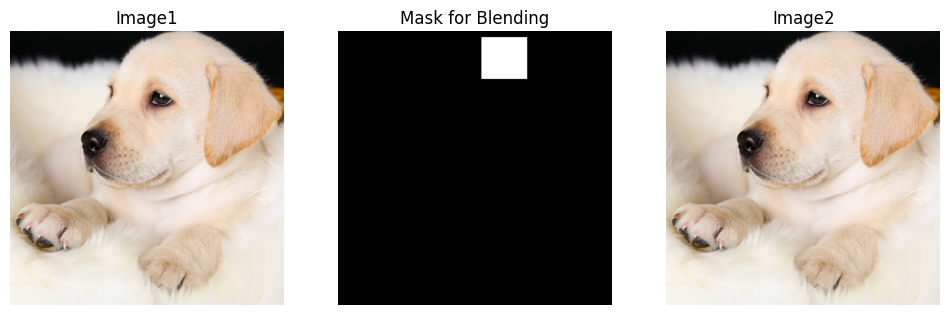

In [842]:
# get the mask from the mask image (second image)
mask = getMask(mask_image)

# get the region to mask from input image (first image)
region_to_mask = getRegionToMask(input_image)

image1 = input_image
image2, mask_for_blending = setMaskImage(mask_image, region_to_mask, mask)
#mask_for_blending = np.zeros_like(input_image[:, :, 0]) 

#mask_for_blending[int(region_to_mask[1]):int(region_to_mask[1] + region_to_mask[3]),
 #    int(region_to_mask[0]):int(region_to_mask[0] + region_to_mask[2])] = 255

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(image1, cmap='gray')
plt.title("Image1")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(mask_for_blending, cmap='gray')
plt.title("Mask for Blending")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(mask_image, cmap='gray')
plt.title("Image2")
plt.axis('off')
plt.show()

In [843]:
mask_for_blending
image1 = image1.astype(np.float64) / 255.0
image2 = image2.astype(np.float64) / 255.0

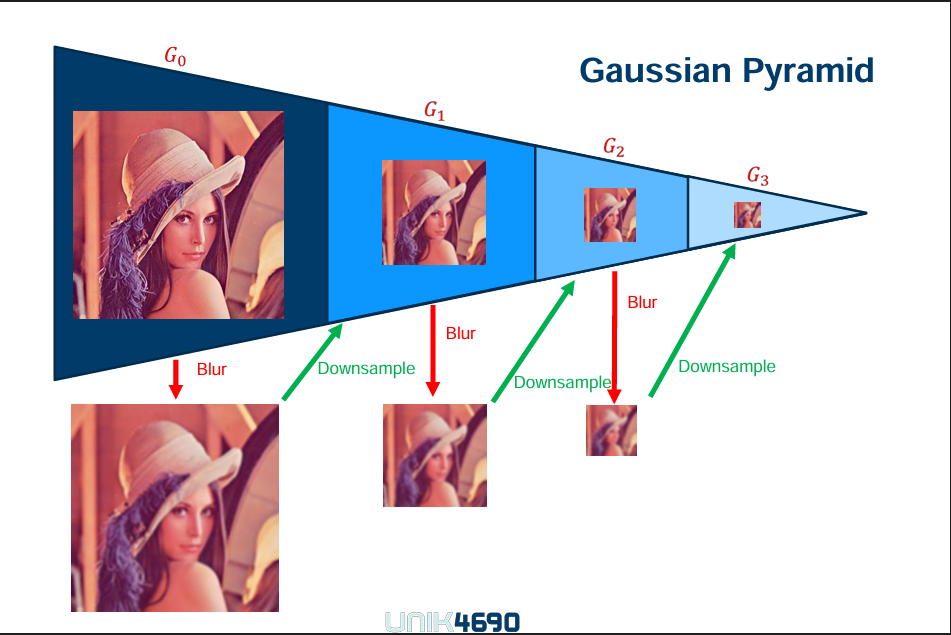

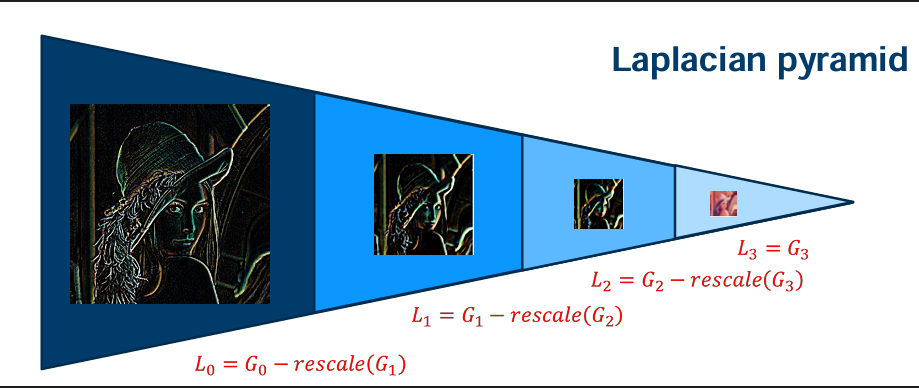

In [844]:
kernel_size = (5, 5)
sigma_value = 1.6


In [845]:
def downsample(image):
    return image[::2, ::2]

def upsample(image, target_shape):
    return cv2.resize(image, (target_shape[1], target_shape[0]))

def smooth_image(image):
    return cv2.GaussianBlur(image, kernel_size, sigma_value)

def gaussianPyr(image, number_of_levels):
    gaussian_pyramid = [image]
    for i in range(number_of_levels - 1):
        image = smooth_image(image)
        image = downsample(image)
        gaussian_pyramid.append(image)
    return gaussian_pyramid

def laplacianPyr(image, number_of_levels):
    gaussian_pyramid = gaussianPyr(image, number_of_levels)
    laplacian_pyramid = [gaussian_pyramid[number_of_levels - 1]]

    for i in range(number_of_levels - 1, 0, -1):
        expanded = upsample(gaussian_pyramid[i], gaussian_pyramid[i - 1].shape)
        laplacian = gaussian_pyramid[i - 1] - expanded
        laplacian_pyramid.insert(0, laplacian)

    return laplacian_pyramid

def collapsePyr(laplacian_pyramid):
    reconstructed = laplacian_pyramid[-1]

    for laplacian_level in reversed(laplacian_pyramid[:-1]):
        reconstructed = laplacian_level + upsample(reconstructed, laplacian_level.shape)

    return reconstructed


In [846]:
def blend(image1, image2, mask_for_blending, number_of_levels):

    # create laplacian pyramids for both images
    laplacian_pyramid1 = laplacianPyr(image1, number_of_levels)
    laplacian_pyramid2 = laplacianPyr(image2, number_of_levels)

    # Builda Gaussianpyramid for each region mask
    Rgaus = gaussianPyr(mask_for_blending, number_of_levels)

    blended_pyramid = []

    # blend each level of the pyramid using the region mask
    for i in range(len(laplacian_pyramid1)):

        L1 = laplacian_pyramid1[i]
        L2 = laplacian_pyramid2[i]
        R = Rgaus[i]

        # Blend each level of pyramid using region mask from the same level:
        L = L1 * R + L2 * (1 - R)
        blended_pyramid.append(L)

    # Collapse the pyramid to getthe final blended image.
    final_blended_image = collapsePyr(blended_pyramid)

    return final_blended_image, blended_pyramid

In [847]:
#number_of_levels = int(np.floor(np.log2(min(image.shape[0], image.shape[1]))))

In [905]:
number_of_levels = 5
blended, blended_pyramid = blend(image2,image1,mask_for_blending, number_of_levels)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 1799.5, 1799.5, -0.5)

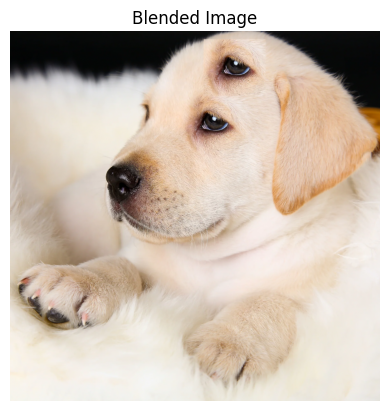

In [906]:
plt.imshow(blended)
plt.title("Blended Image")
plt.axis('off')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


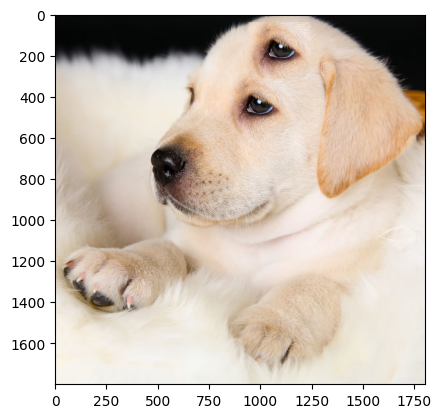

ValueError: Floating point image RGB values must be in the 0..1 range.

In [907]:
plt.imshow(blended)
plt.show()
output_path = "dog9.png"  # Replace with your desired file path and format
plt.imsave(output_path, blended)
print(f"Image saved to {output_path}")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


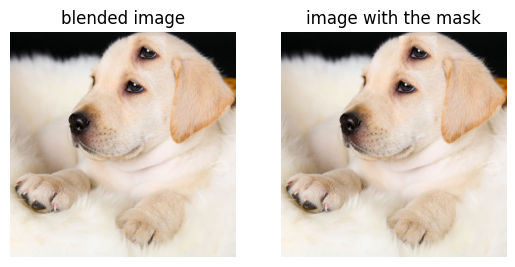

In [ ]:
plt.subplot(1, 2, 1)
plt.imshow(blended)
plt.title('blended image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(image2)
plt.title('image with the mask')
plt.axis('off')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
norm = mcolors.Normalize(vmin=0, vmax=1)

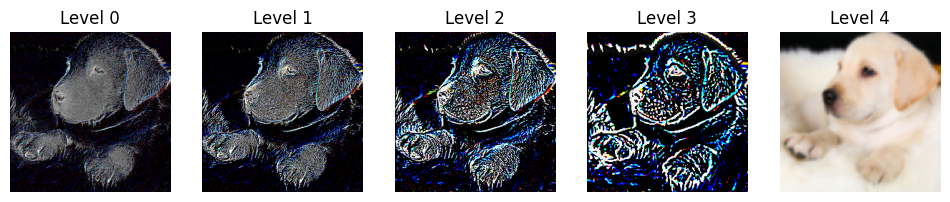

In [ ]:
l1 = laplacianPyr(image1, number_of_levels)
plt.figure(figsize=(12, 4))
for i, image in enumerate(l1):
    # Normalize the Laplacian image to the range [0, 255]
    normalized_image = (image * 255).astype(np.uint8)
    
    plt.subplot(1, len(l1), i + 1)
    plt.imshow(normalized_image, cmap='viridis', norm=norm)
    plt.title(f'Level {i}')
    plt.axis('off')

plt.show()

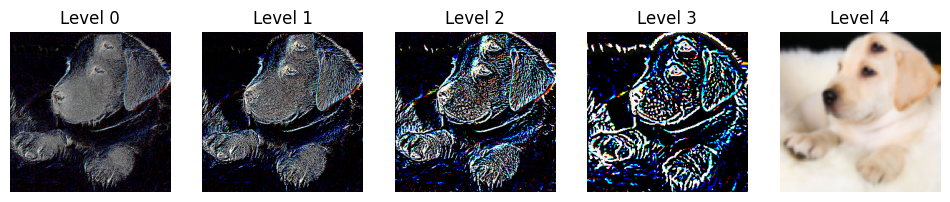

In [ ]:
l2 = laplacianPyr(image2, number_of_levels)
plt.figure(figsize=(12, 4))
for i, image in enumerate(l2):
    normalized_image = (image * 255).astype(np.uint8)
    
    plt.subplot(1, len(l2), i + 1)
    plt.imshow(normalized_image, cmap='viridis', norm=norm)
    plt.title(f'Level {i}')
    plt.axis('off')

plt.show()

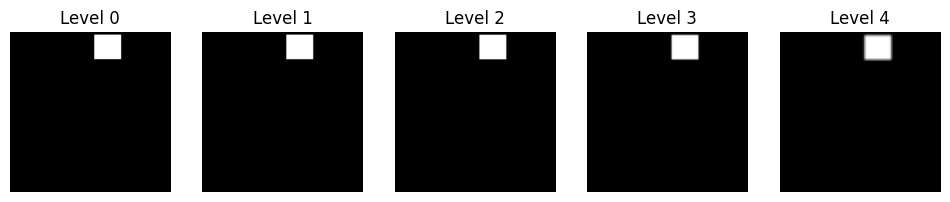

In [ ]:
Rgaus = gaussianPyr(mask_for_blending, number_of_levels)
plt.figure(figsize=(12, 4))
for i, gaussian_image in enumerate(Rgaus):
    plt.subplot(1, len(Rgaus), i + 1)
    plt.imshow(gaussian_image)
    plt.title(f'Level {i}')
    plt.axis('off')

plt.show()

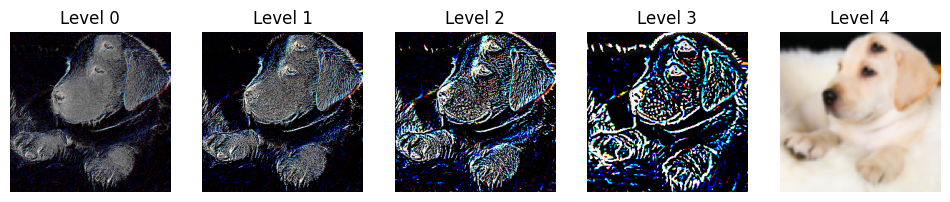

In [ ]:
plt.figure(figsize=(12, 4))
for i, image in enumerate(blended_pyramid):
    normalized_image = (image * 255).astype(np.uint8)
    
    plt.subplot(1, len(l1), i + 1)
    plt.imshow(normalized_image, cmap='viridis', norm=norm)
    plt.title(f'Level {i}')
    plt.axis('off')

plt.show()